 # Cross-Validation Results

In [364]:
import csv # csv reader
from sklearn.svm import LinearSVC
!pip install nltk
import nltk
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
#import pandas as pd
import regex as re

In [365]:
def load_data(path):
    #Load data from a tab-separated file and append it to raw_data.
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    #Split the data between train_data and test_data according to the percentageand performs the preprocessing.
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        token = pre_process(text)
        train_data.append((to_feature_vector(token),label))
        train_word_count.append(len(token))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(token),label))
        test_word_count.append(len(token))

In [366]:
def parse_data_line(data_line):
    label = data_line[1]
    text = data_line[2]
    return (label, text)

In [370]:
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    # sentence segmentation - assume already done
    # word tokenisation
    
    #Hyperlink removal
    text = re.sub(r"htt.\S+", '' ,text)
    tokens = re.split(r"\s+",text)
    # normalisation - only by lower casing for now
    tokens = [t.lower() for t in tokens]

    #Stop words removal 
    stop_words = set(stopwords.words('english'))
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    #Lemmatization 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

# test after pre-processing and print the result
pre_process("London is the beautiful city, you should visit once.")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['london', 'beautiful', 'city,', 'visit', 'once.']

In [371]:
!pip install scikit-learn
from sklearn.feature_extraction.text import CountVectorizer

In [372]:
from collections import Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

global_feature_dict = Counter()

def to_feature_vector(tokens):
    
    '''
    Define your method here - TBD
    '''
    # Create bigrams
    bigrams = list(ngrams(tokens, 2))

    # Combine tokens and bigrams for feature extraction
    features = tokens + [' '.join(bigram) for bigram in bigrams]

    # Initialize a CountVectorizer to count word frequencies
    vectorizer = CountVectorizer(ngram_range=(1, 2))

    # Fit and transform the tokens to get the bag-of-words representation
    feature_vector_sparse = vectorizer.fit_transform(features)

    # Convert the sparse matrix to a dense array
    feature_vector_dense = feature_vector_sparse.toarray()

    # Extract the feature names (words in the vocabulary)
    feature_names = vectorizer.get_feature_names_out()

    # Create a Counter with the feature names as keys and their frequency values
    feature_vector = Counter({feature_names[i]: feature_vector_dense[0][i] for i in range(len(feature_names))})

    # Update the global feature dictionary
    global_feature_dict.update(feature_vector)
    # Using binary feature value ie will give weight as 1 for the token present
    feature_vector = {feature: 1 for feature in feature_names}
    return feature_vector

# Test and print the result
token = pre_process("Conor McGregor backed up the talk and won interim gold with 2nd Round TKO. http://t.co/XAadtJ8IUV http://t.co/wP5juh3vQB")
result = to_feature_vector(token)
print(result)

{'2nd': 1, '2nd round': 1, 'backed': 1, 'backed talk': 1, 'conor': 1, 'conor mcgregor': 1, 'gold': 1, 'gold 2nd': 1, 'interim': 1, 'interim gold': 1, 'mcgregor': 1, 'mcgregor backed': 1, 'round': 1, 'round tko': 1, 'talk': 1, 'talk interim': 1, 'tko': 1}


In [373]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")

    # Testing what happen when playign with C (cost parameter)
    pipeline =  Pipeline([('svc', LinearSVC())])
    
    # Testing what happen when adding class weight
    # class_weight_value={1: 1.0, 0: 10.0}
    # pipeline =  Pipeline([('svc', LinearSVC(dual='auto', C=1.0, class_weight=class_weight_value))])

    #Testing what happen when increasing the value of the class weight
    # class_weight_value={1: 1.0, 0: 100.0} 
    # pipeline =  Pipeline([('svc', LinearSVC(dual='auto', C=1.0, class_weight=class_weight_value, max_iter= 100000))])
    return SklearnClassifier(pipeline).train(data)

In [374]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import KFold

def cross_validate(dataset, folds):
    '''
    This function takes datset and perform N-fold cross validation and retruns
    aggregated results in cv_results
    
    Parameter:
        Takes dataset and fold as Input
        eg: [], 10

    Return:
        Dictionary of classification metrics with arrgregated values
    '''
    results = []
    fold_size = int(len(dataset) / folds)
    # Split the data into features and labels
    feature_tokens_for_classification = [data[0] for data in dataset]
    labels_for_dataset = [data[1] for data in dataset]
 
    # Use KFold to split the data into training and test sets for each fold
    kfold = KFold(n_splits=folds, shuffle=False)
 
    for train_pointers, test_pointers in kfold.split(feature_tokens_for_classification):
        '''
        Splitting the data into test and train for 10 - fold analysis
        Then we are going to train teh classifier usign the train_classifier functijn
        predict values and then evaluate the metrics
        '''
        xTrain, xTest = [feature_tokens_for_classification[i] for i in train_pointers], [feature_tokens_for_classification[i] for i in test_pointers]
        yTrain, yTest = [labels_for_dataset[i] for i in train_pointers], [labels_for_dataset[i] for i in test_pointers]
 
        # Training your clasifier here - :)
        model_training = train_classifier(list(zip(xTrain, yTrain)))
 
        # Lets predict the label for the test data
        predicted_labels = predict_labels(xTest, model_training)
 
        # Lets measure the classification metrics
        precision, recall, f1_score, _ = precision_recall_fscore_support(
            yTest, predicted_labels, average='weighted')
        accuracy = accuracy_score(yTest, predicted_labels)
 
        results.append({
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'accuracy': accuracy
        })

    cv_results = {
        'precision': sum(result['precision'] for result in results) / len(results),
        'recall': sum(result['recall'] for result in results) / len(results),
        'f1_score': sum(result['f1_score'] for result in results) / len(results),
        'accuracy': sum(result['accuracy'] for result in results) / len(results),
    }
    return cv_results


In [375]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(pre_process(samples)))

def get_avg_count(dataset):
    #styling
    return sum([count for item, count in global_feature_dict.items()])/len(dataset)

In [376]:
# MAIN
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset
train_word_count = []
test_word_count = []

# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')

avg_train= int(sum(train_word_count)/len(train_word_count))
avg_test= int(sum(test_word_count)/len(test_word_count))
print("The average count of word in the sentance is {} for the train data".format(avg_train))
print("The average count of word in the sentance is {} for the test data".format(avg_test))

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
251654
The average count of word in the sentance is 11 for the train data
The average count of word in the sentance is 10 for the test data


In [377]:
cross_validate(train_data, 10) # will work and output overall performance of p, r, f-score when cv implemented

Training Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


{'precision': 0.8527711341492573,
 'recall': 0.8546509373751942,
 'f1_score': 0.8521183671878161,
 'accuracy': 0.8546509373751942}

Training Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


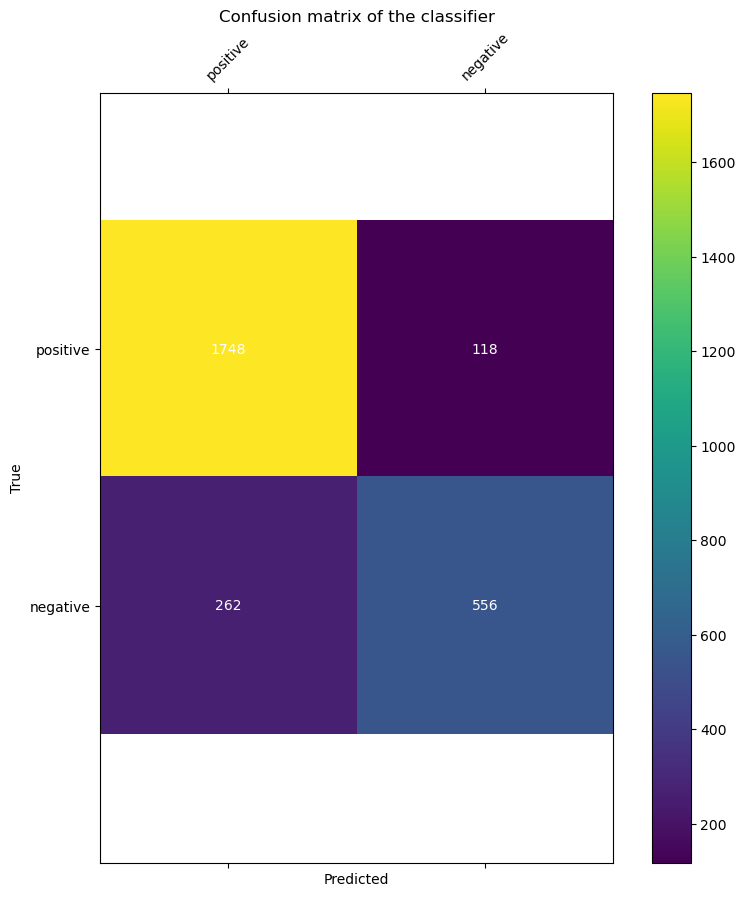

2684
2684
2684


In [378]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()


# Split the dataset into training and testing sets
test_data = train_data[ 0:2684]
train_data = train_data[:0] + train_data[2684:]

# print("Fold start on items %d - %d" % (i, i+fold_size))
# FILL IN THE METHOD HERE

# Extract features (X) and labels (y) from the training and testing sets

X_train = [text for text, label in train_data]
y_train = [label for text, label in train_data]
X_test = [text for text, label in test_data]
y_test = [label for text, label in test_data]

# Train the classifier

classifier = train_classifier(list(zip(X_train, y_train)))

# Predict labels for the test set

y_pred = [classifier.classify(text) for text in X_test]

# Evaluate performance metrics

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)


confusion_matrix_heatmap(y_test, y_pred, labels=['positive', 'negative'])

print(len(X_test))
print(len(y_test))
print(len(y_pred))


#False Positive and False Negative 

rows_of_csv = []
for text, label, pred_label in zip(X_test, y_test, y_pred):
    if pred_label == label: # correct/TP, ignore these
        continue

    rows_of_csv.append([label, pred_label, text])

with open("Sentiment_FN_FP.csv", mode='w', newline='') as file:
    write = csv.writer(file)

    for row in rows_of_csv:
        write.writerow(row)




In [379]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

   

({'concert': 1, 'concert october': 1, 'excited': 1, 'going': 1, 'going sam': 1, 'literally': 1, 'literally excited': 1, 'october': 1, 'sam': 1, 'sam smith': 1, 'smith': 1, 'smith concert': 1}, 'positive')
Training Classifier...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Done training!
Precision: 0.856021
Recall: 0.858420
F Score:0.854218
